In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import random
%matplotlib inline

import openpyxl

# Outdoor

## Experiment 1

In [6]:
train_frame_no = 1
test_frame_no = train_frame_no + 5
train_frame = cv2.imread('data_outdoor/right_images_subset/scene_1.png')

#Creating relevant objects
extractor = cv2.BRISK_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING)

#Initializing Excel sheet
wb = openpyxl.load_workbook('Results for Experiments on Image features.xlsx')
worksheet = wb.active
worksheet.title = 'Experiment 1'
column = 2

while True:
    test_frame = cv2.imread('data_outdoor/right_images_subset/scene_' + str(test_frame_no) + '.png')
    if test_frame is None:
        break

    # Convert the images to gray scale
    train_gray = cv2.cvtColor(train_frame, cv2.COLOR_BGR2GRAY)
    test_gray = cv2.cvtColor(test_frame, cv2.COLOR_BGR2GRAY)

    # FEATURE EXTRACTION 
    train_keypoints, train_descriptor = extractor.detectAndCompute(train_gray, None)
    test_keypoints, test_descriptor = extractor.detectAndCompute(test_gray, None)

    # FEATURE MATCHING
    matches = bf.knnMatch(train_descriptor, test_descriptor,k=2)

    # Extracting 'Good' matches using ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            good.append(m)

    # NOW PRINTING THE METRIC 1 SCORE
    good_matches = len(good)
    mean_keypoints = int((len(train_keypoints)+len(test_keypoints))/2)
    print("Metric 1 score for frames",train_frame_no,"-",test_frame_no,":",good_matches,'/',mean_keypoints)

    # Filling the excel sheet
    worksheet.cell(row=6,column=column).value = str(good_matches)+' / '+str(mean_keypoints)
    column = column + 1
    
    train_frame = test_frame
    train_frame_no = train_frame_no + 5
    test_frame_no = test_frame_no + 5

wb.save('Results for Experiments on Image features.xlsx')

Metric 1 score for frames 1 - 6 : 2360 / 7295
Metric 1 score for frames 6 - 11 : 2289 / 7240
Metric 1 score for frames 11 - 16 : 98 / 8697
Metric 1 score for frames 16 - 21 : 3451 / 10026
Metric 1 score for frames 21 - 26 : 128 / 7989
Metric 1 score for frames 26 - 31 : 1508 / 6072
Metric 1 score for frames 31 - 36 : 103 / 6370
Metric 1 score for frames 36 - 41 : 1747 / 6389
Metric 1 score for frames 41 - 46 : 2694 / 6199


## Experiment 2

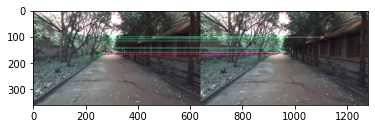

No of 'Good' matches betn 1 - 6 : 1189


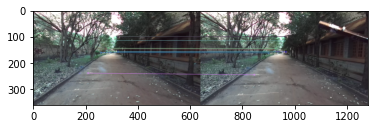

No of 'Good' matches betn 1 - 11 : 780


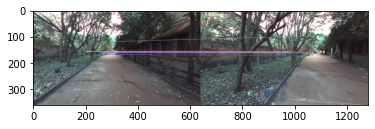

No of 'Good' matches betn 1 - 16 : 70


In [ ]:
train_frame_no = 1
test_frame_no = train_frame_no + 5
train_frame = cv2.imread('data_outdoor/right_images_subset/scene_1.png')
train_frame = cv2.resize(train_frame, None, fx=0.5, fy=0.5)
train_gray = cv2.cvtColor(train_frame, cv2.COLOR_BGR2GRAY)

#Creating relevant objects -- CHANGE ONLY THESE TO CHANGE THE FEATURE EXTRACTION ALGORITHM
extractor = cv2.BRISK_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING)

train_keypoints, train_descriptor = extractor.detectAndCompute(train_gray, None)

while True:
    test_frame = cv2.imread('data_outdoor/right_images_subset/scene_' + str(test_frame_no) + '.png')

    if test_frame is None:
        break

    test_frame = cv2.resize(test_frame, None, fx=0.5, fy=0.5)

    # Convert the image to gray scale
    test_gray = cv2.cvtColor(test_frame, cv2.COLOR_BGR2GRAY)

    # FEATURE EXTRACTION 
    test_keypoints, test_descriptor = extractor.detectAndCompute(test_gray, None)

    # FEATURE MATCHING
    matches = bf.knnMatch(train_descriptor, test_descriptor,k=2)

    # Extracting 'Good' matches using ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            good.append(m)
    good = sorted(good, key = lambda x : x.distance)
    num_good = len(good)

    result_to_show = cv2.drawMatches(train_frame, train_keypoints, test_frame, test_keypoints, good[:10],None,flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(result_to_show),plt.show()

    # Printing the no of 'Good' matches
    print("No of 'Good' matches betn",train_frame_no,"-",test_frame_no,":",num_good)

    # MANUAL INSPECTION STAGE
    if num_good <= 20:
        result = cv2.drawMatches(train_frame, train_keypoints, test_frame, test_keypoints, good,None,flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

        cv2.imshow('matches betn 1-'+str(test_frame_no),result)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    else:
        for i in range(2):
            random.shuffle(good)
            result = cv2.drawMatches(train_frame, train_keypoints, test_frame, test_keypoints, good[:10],None,flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

            # Without replacement
            good = good[10:]

            cv2.imshow('matches '+str(i+1)+' betn 1-'+str(test_frame_no),result)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

    test_frame_no = test_frame_no + 5

## Experiment 3 - Feature Tracking

In [4]:
#INITIALISATIONS
    
train_frame_no = 1
test_frame_no = train_frame_no + 1
train_frame = cv2.imread('data_outdoor/right_images_subset/scene_1.png')

#Creating relevant objects    ------ ONLY THIS SECTION HAS TO BE CHANGED
extractor = cv2.BRISK_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
row = 6

#More initializations
train_gray = cv2.cvtColor(train_frame, cv2.COLOR_BGR2GRAY)
train_keypoints, train_descriptor = extractor.detectAndCompute(train_gray, None)
good_prev = []
total_reduction = 0
num_features_initial = len(train_keypoints)
print('Initial number of features detected in frame 1:', num_features_initial-total_reduction)

#Excel sheet things
wb = openpyxl.load_workbook('Results for Experiments on Image features.xlsx')
worksheet = wb['Experiment 3']
column = 2

worksheet.cell(row=row,column=column).value = num_features_initial
column = column + 1

while True:
    
    test_frame = cv2.imread('data_outdoor/right_images_subset/scene_' + str(test_frame_no) + '.png')

    if test_frame is None:
        break

    # Convert the images to gray scale
    test_gray = cv2.cvtColor(test_frame, cv2.COLOR_BGR2GRAY)

    # FEATURE EXTRACTION 
    test_keypoints, test_descriptor = extractor.detectAndCompute(test_gray, None)

    # FEATURE MATCHING
    matches = bf.knnMatch(train_descriptor, test_descriptor,k=2)

    # Extracting 'Good' matches using ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.9*n.distance:
            good.append(m)
     
    retained_features = []
    reduction = 0
    for match_prev in good_prev:
        value = match_prev.trainIdx
        found = False
        
        for index, match in enumerate(good):
            if match.queryIdx == value:
                retained_features.append(match)
                good.pop(index)      #Removing further unwanted match for increasingly efficient search
                
                found = True
                break        

        if not found:
            reduction = reduction + 1

    total_reduction = total_reduction + reduction
    
    if (test_frame_no-1) % 5 == 0:   #Documenting status at some intermediate frames
        print('Number of features retained till frame',test_frame_no,'is:', num_features_initial-total_reduction)
        
        # Filling the excel sheet
        worksheet.cell(row=row,column=column).value = num_features_initial-total_reduction
        column = column + 1
    
    # LOOP UPDATES
    train_frame = test_frame
    train_gray = test_gray
    train_keypoints, train_descriptor = test_keypoints, test_descriptor
    
    if test_frame_no == 2:
        good_prev = good
    else:
        good_prev = retained_features  #Important assignment
    
    test_frame_no = test_frame_no + 1
    
wb.save('Results for Experiments on Image features.xlsx')

Initial number of features detected in frame 1: 7326
Number of features retained till frame 6 is: 3813
Number of features retained till frame 11 is: 2949
Number of features retained till frame 16 is: 2336
Number of features retained till frame 21 is: 2319
Number of features retained till frame 26 is: 2306
Number of features retained till frame 31 is: 2305
Number of features retained till frame 36 is: 2305
Number of features retained till frame 41 is: 2304
Number of features retained till frame 46 is: 2304


# Indoor

## Experiment 1

In [9]:
train_frame_no = 1
test_frame_no = train_frame_no + 20
train_frame = cv2.imread('data_indoor/frame1.png')

#Creating relevant objects    --- ONLY CHANGE THIS SECTION 
extractor = cv2.BRISK_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
row = 6

#Initializing Excel sheet
wb = openpyxl.load_workbook('Results for Experiments on Image features_INDOOR.xlsx')
worksheet = wb.active
column = 2

while True:
    test_frame = cv2.imread('data_indoor/frame' + str(test_frame_no) + '.png')
    if test_frame is None:
        break

    # Convert the images to gray scale
    train_gray = cv2.cvtColor(train_frame, cv2.COLOR_BGR2GRAY)
    test_gray = cv2.cvtColor(test_frame, cv2.COLOR_BGR2GRAY)

    # FEATURE EXTRACTION 
    train_keypoints, train_descriptor = extractor.detectAndCompute(train_gray, None)
    test_keypoints, test_descriptor = extractor.detectAndCompute(test_gray, None)

    # FEATURE MATCHING
    matches = bf.knnMatch(train_descriptor, test_descriptor,k=2)

    # Extracting 'Good' matches using ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            good.append(m)

    # NOW PRINTING THE METRIC 1 SCORE
    good_matches = len(good)
    mean_keypoints = int((len(train_keypoints)+len(test_keypoints))/2)
    print("Metric 1 score for frames",train_frame_no,"-",test_frame_no,":",good_matches,'/',mean_keypoints)

    # Filling the excel sheet
    #worksheet.cell(row=1,column=column).value = str(train_frame_no)+' - '+str(test_frame_no)
    worksheet.cell(row=row,column=column).value = str(good_matches)+' / '+str(mean_keypoints)
    column = column + 1
    
    train_frame = test_frame
    train_frame_no = train_frame_no + 20
    test_frame_no = test_frame_no + 20

wb.save('Results for Experiments on Image features_INDOOR.xlsx')

Metric 1 score for frames 1 - 21 : 5198 / 6849
Metric 1 score for frames 21 - 41 : 3128 / 6832
Metric 1 score for frames 41 - 61 : 1786 / 6353
Metric 1 score for frames 61 - 81 : 978 / 5646
Metric 1 score for frames 81 - 101 : 537 / 3968
Metric 1 score for frames 101 - 121 : 305 / 1540
Metric 1 score for frames 121 - 141 : 160 / 717
Metric 1 score for frames 141 - 161 : 176 / 854
Metric 1 score for frames 161 - 181 : 174 / 1071
Metric 1 score for frames 181 - 201 : 1056 / 1292
Metric 1 score for frames 201 - 221 : 1032 / 1288


## Experiment 3 - Feature Tracking

In [14]:
#INITIALISATIONS
    
train_frame_no = 1
test_frame_no = train_frame_no + 1
train_frame = cv2.imread('data_indoor/frame1.png')

#Creating relevant objects    ------ ONLY THIS SECTION HAS TO BE CHANGED
extractor = cv2.BRISK_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
row = 6

#More initializations
train_gray = cv2.cvtColor(train_frame, cv2.COLOR_BGR2GRAY)
train_keypoints, train_descriptor = extractor.detectAndCompute(train_gray, None)
good_prev = []
total_reduction = 0
num_features_initial = len(train_keypoints)
print('Initial number of features detected in frame 1:', num_features_initial-total_reduction)

#Excel sheet things
wb = openpyxl.load_workbook('Results for Experiments on Image features_INDOOR.xlsx')
worksheet = wb['Experiment 3']
column = 2

worksheet.cell(row=row,column=column).value = num_features_initial
column = column + 1

while True:
    
    test_frame = cv2.imread('data_indoor/frame' + str(test_frame_no) + '.png')

    if test_frame is None:
        break

    # Convert the images to gray scale
    test_gray = cv2.cvtColor(test_frame, cv2.COLOR_BGR2GRAY)

    # FEATURE EXTRACTION 
    test_keypoints, test_descriptor = extractor.detectAndCompute(test_gray, None)

    # FEATURE MATCHING
    matches = bf.knnMatch(train_descriptor, test_descriptor,k=2)

    # Extracting 'Good' matches using ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.9*n.distance:
            good.append(m)
     
    retained_features = []
    reduction = 0
    for match_prev in good_prev:
        value = match_prev.trainIdx
        found = False
        
        for index, match in enumerate(good):
            if match.queryIdx == value:
                retained_features.append(match)
                good.pop(index)      #Removing further unwanted match for increasingly efficient search
                
                found = True
                break        

        if not found:
            reduction = reduction + 1

    total_reduction = total_reduction + reduction
    
    if (test_frame_no-1) % 20 == 0:   #Documenting status at some intermediate frames
        print('Number of features retained till frame',test_frame_no,'is:', num_features_initial-total_reduction)
        
        # Filling the excel sheet
        #worksheet.cell(row=1,column=column).value = 'Until frame '+str(test_frame_no)
        worksheet.cell(row=row,column=column).value = num_features_initial-total_reduction
        column = column + 1
    
    # LOOP UPDATES
    train_frame = test_frame
    train_gray = test_gray
    train_keypoints, train_descriptor = test_keypoints, test_descriptor
    
    if test_frame_no == 2:
        good_prev = good
    else:
        good_prev = retained_features  #Important assignment
    
    test_frame_no = test_frame_no + 1
    
wb.save('Results for Experiments on Image features_INDOOR.xlsx')

Initial number of features detected in frame 1: 6877
Number of features retained till frame 21 is: 3774
Number of features retained till frame 41 is: 1347
Number of features retained till frame 61 is: 923
Number of features retained till frame 81 is: 874
Number of features retained till frame 101 is: 867
Number of features retained till frame 121 is: 866
Number of features retained till frame 141 is: 865
Number of features retained till frame 161 is: 864
Number of features retained till frame 181 is: 864
Number of features retained till frame 201 is: 864
Number of features retained till frame 221 is: 864
